## Experiments

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import torch
import time

import sys
sys.path.append('..')

import pickle

from core import logreg, utility
from core.samplers_torch import DGibbs, Gibbs
from core.dHMC import DHMCSampler

In [3]:
def run_chain(sampler, state0, n_steps, n_samples, device):
    sampler.initialize(state0)    
    x, weights = torch.zeros([n_samples, sampler.dist.size]), torch.zeros([n_samples, 1])
    start = time.time()
    for x_id in range(n_samples):
        x[x_id], weights[x_id] = sampler.iterate_n(n_steps)
    return x.to(device), weights.to(device), time.time() - start

def save_true_mean(target_dist, device, num_bits, name):
    target = target_dist(num_bits=num_bits, prior='uniform', cv_folds=1)
    target.device = device
    target.X_train = target.X_train.to(device)
    target.y_train = target.y_train.to(device)
    gibbs = Gibbs(target)
    state0 = torch.zeros(target.size).to(device)
    samples_gibbs, weights_gibbs, t_gibbs = run_chain(gibbs, state0, target.size, 5000, device)
    mean = torch.mean(samples_gibbs, dim=0).cpu().numpy()
    destination = '../data/{}_true_mean'.format(name)
    np.save(destination, mean)

In [4]:
save_true_mean(logreg.LogisticRegressionIris, torch.device('cpu'), 1, 'iris')
save_true_mean(logreg.LogisticRegressionWine, torch.device('cpu'), 1, 'wine')
save_true_mean(logreg.LogisticRegressionBreastCancer, torch.device('cuda:0'), 1, 'cancer')
save_true_mean(logreg.LogisticRegressionDigits, torch.device('cuda:0'), 1, 'digits')

## Regression for different datasets

In [21]:
def get_target(target_dist, device, num_bits):
    target = target_dist(num_bits=num_bits, prior='uniform', cv_folds=1)
    target.device = device
    target.X_train = target.X_train.to(device)
    target.y_train = target.y_train.to(device)
    return target

def evaluate_sampler(sampler, target, device, init_states, true_mean):
    n_exps = init_states.shape[0]
    n_samples = 1000
    errors = torch.zeros([n_exps, n_samples])
    accs = torch.zeros([n_exps, n_samples])
    times = np.zeros(n_exps)
    for exp_id in range(n_exps):
        state0 = init_states[exp_id].to(device)
        samples, weights, t = run_chain(sampler, state0, 1, n_samples, device)
        times[exp_id] = t
        weights[weights < 1e-20] = 1e-20
        means = torch.cumsum(samples*weights, dim=0)/torch.cumsum(weights, dim=0)
        errors[exp_id] = torch.sum(torch.abs(means-true_mean.reshape([1,means.shape[1]])), dim=1)
        for i in range(n_samples):
            w = weights[:i+1].clone()
            accs[exp_id,i] = target.accuracy(samples[:i+1], w.reshape([1,1,-1])/torch.sum(w))
    return errors.cpu().numpy(), accs.cpu().numpy(), times

def run_dHMC(dhmc, state0, n_steps, n_samples, device):
    dt = 0.9 * np.array([.8, 1])
    nstep = [1,2]
    start = time.time()
    x, logp_samples, time_elapsed = dhmc.run_sampler(state0.cpu().numpy(), dt, nstep, 
                                                     n_burnin=0, n_sample=n_samples, 
                                                     seed=1, n_update=1)
    weights = torch.ones([n_samples,1]).to(device)
    x = torch.from_numpy(np.floor(x)).float().to(device)
    return x, weights, time.time() - start

def evaluate_dHMC(dHMC, target, device, init_states, true_mean):
    n_exps = init_states.shape[0]
    n_samples = 1000
    errors = torch.zeros([n_exps, n_samples])
    accs = torch.zeros([n_exps, n_samples])
    times = np.zeros(n_exps)
    for exp_id in range(n_exps):
        state0 = init_states[exp_id].to(device)
        samples, weights, t = run_dHMC(dHMC, state0, 1, n_samples, device)
        times[exp_id] = t
        means = torch.cumsum(samples*weights, dim=0)/torch.cumsum(weights, dim=0)
        errors[exp_id] = torch.sum(torch.abs(means-true_mean.reshape([1,means.shape[1]])), dim=1)
        for i in range(n_samples):
            w = weights[:i+1].clone()
            accs[exp_id,i] = target.accuracy(samples[:i+1], w.reshape([1,1,-1])/torch.sum(w))
    return errors.cpu().numpy(), accs.cpu().numpy(), times

def run_experiment(name):
    if name == 'iris':
        target_dist = logreg.LogisticRegressionIris
        device = torch.device('cpu')
    if name == 'wine':
        target_dist = logreg.LogisticRegressionWine
        device = torch.device('cpu')
    if name == 'cancer':
        target_dist = logreg.LogisticRegressionBreastCancer
        device = torch.device('cpu')
    if name == 'digits':
        target_dist = logreg.LogisticRegressionDigits
        device = torch.device('cpu')
    
    target = get_target(target_dist, device, 1)
    true_mean = np.load('../data/{}_true_mean.npy'.format(name))
    true_mean = torch.from_numpy(true_mean).to(device)

    gibbs = Gibbs(target)
    primes = utility.generate_primes(100000)
    gibbs_d = DGibbs(target, v_coeffs=torch.tensor(np.sqrt(primes)[:target.size]).to(device))
    gibbs_d.dims = gibbs_d.dims.to(device)
    suzuki = DGibbs(target)
    suzuki.dims = suzuki.dims.to(device)
    dhmc = DHMCSampler(target.get_f(), target.get_f_update(), target.size, target.size)
    
    init_states = (torch.rand([10, target.size]) > 0.5).to(device).float()
    errors_gibbs, accs_gibbs, t_gibbs = evaluate_sampler(gibbs, target, device, 
                                                         init_states.clone(), true_mean)
    errors_dhmc, accs_dhmc, t_dhmc = evaluate_dHMC(dhmc, target, device, 
                                                   init_states.clone(), true_mean)
    errors_suzuki, accs_suzuki, t_suzuki = evaluate_sampler(suzuki, target, device, 
                                                            init_states.clone(), true_mean)
    errors_gibbs_d, accs_gibbs_d, t_gibbs_d = evaluate_sampler(gibbs_d, target, device, 
                                                               init_states.clone(), true_mean)
    results = {
        'gibbs': (errors_gibbs, accs_gibbs, t_gibbs),
        'dhmc': (errors_dhmc, accs_dhmc, t_dhmc),
        'suzuki': (errors_suzuki, accs_suzuki, t_suzuki),
        'gibbs_d': (errors_gibbs_d, accs_gibbs_d, t_gibbs_d)
    }
    with open('../results/logreg/{}.pickle'.format(name), 'wb') as handle:
        pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [22]:
# run_experiment('iris')
# run_experiment('wine')
run_experiment('cancer')
run_experiment('digits')

## Plot results

In [16]:
def plot_results(name):
    with open('../results/logreg/{}.pickle'.format(name), 'rb') as handle:
        results = pickle.load(handle)
    errors_gibbs, accs_gibbs, t_gibbs = results['gibbs']
    errors_dhmc, accs_dhmc, t_dhmc = results['dhmc']
    errors_suzuki, accs_suzuki, t_suzuki = results['suzuki']
    errors_gibbs_d, accs_gibbs_d, t_gibbs_d = results['gibbs_d']
    n_exps, n_samples = errors_gibbs.shape[0], errors_gibbs.shape[1]
    num_samples = np.arange(n_samples) + 1
    sps_gibbs = n_samples/np.mean(t_gibbs)
    sps_dhmc = n_samples/np.mean(t_dhmc)
    sps_suzuki = n_samples/np.mean(t_suzuki)
    sps_gibbs_d = n_samples/np.mean(t_gibbs_d)
    
    figsize(8,8)
    plt.plot(num_samples, np.mean(accs_gibbs,axis=0), label='Gibbs', lw=4)
    plt.plot(num_samples, np.mean(accs_dhmc,axis=0), label='dHMC', lw=4)
    plt.plot(num_samples, np.mean(accs_gibbs_d,axis=0), label='DGibbs', lw=4)

    plt.ylabel('accuracy', fontsize=20)
    plt.xlabel('number of samples', fontsize=20)
    plt.xscale('log')
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.title(name, fontsize=20)
    plt.box(False)
    plt.legend(fontsize=20)
    plt.grid()
    plt.savefig('../results/logreg/{}_accuracy.pdf'.format(name), bbox_inches='tight')
    plt.show()
    
    figsize(8,8)
    plt.plot(num_samples, np.mean(errors_gibbs,axis=0), label='Gibbs', lw=4)
    plt.plot(num_samples, np.mean(errors_dhmc,axis=0), label='dHMC', lw=4)
    plt.plot(num_samples, np.mean(errors_gibbs_d,axis=0), label='DGibbs', lw=4)

    plt.ylabel('errors', fontsize=20)
    plt.xlabel('number of samples', fontsize=20)
    plt.xscale('log')
    plt.yscale('log')
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=10)
    plt.title(name, fontsize=20)
    plt.box(False)
    plt.legend(fontsize=20)
    plt.grid()
    plt.savefig('../results/logreg/{}_errors.pdf'.format(name), bbox_inches='tight')
    plt.show()
    
    figsize(8,8)
    plt.plot(num_samples/sps_gibbs, np.mean(accs_gibbs,axis=0), label='Gibbs', lw=4)
    plt.plot(num_samples/sps_dhmc, np.mean(accs_dhmc,axis=0), label='dHMC', lw=4)
    plt.plot(num_samples/sps_gibbs_d, np.mean(accs_gibbs_d,axis=0), label='DGibbs', lw=4)

    plt.ylabel('accuracy', fontsize=20)
    plt.xlabel('seconds', fontsize=20)
    plt.xscale('log')
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.title(name, fontsize=20)
    plt.box(False)
    plt.legend(fontsize=20)
    plt.grid()
    plt.savefig('../results/logreg/{}_accuracy_seconds.pdf'.format(name), bbox_inches='tight')
    plt.show()
    
    figsize(8,8)
    plt.plot(num_samples/sps_gibbs, np.mean(errors_gibbs,axis=0), label='Gibbs', lw=4)
    plt.plot(num_samples/sps_dhmc, np.mean(errors_dhmc,axis=0), label='dHMC', lw=4)
    plt.plot(num_samples/sps_gibbs_d, np.mean(errors_gibbs_d,axis=0), label='DGibbs', lw=4)

    plt.ylabel('errors', fontsize=20)
    plt.xlabel('seconds', fontsize=20)
    plt.xscale('log')
    plt.yscale('log')
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=10)
    plt.title(name, fontsize=20)
    plt.box(False)
    plt.legend(fontsize=20)
    plt.grid()
    plt.savefig('../results/logreg/{}_errors_seconds.pdf'.format(name), bbox_inches='tight')
    plt.show()

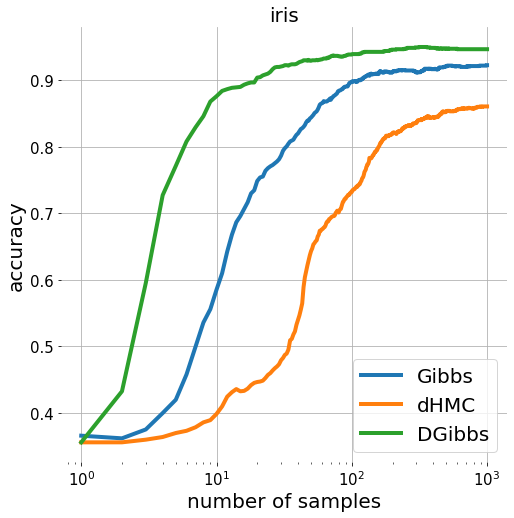

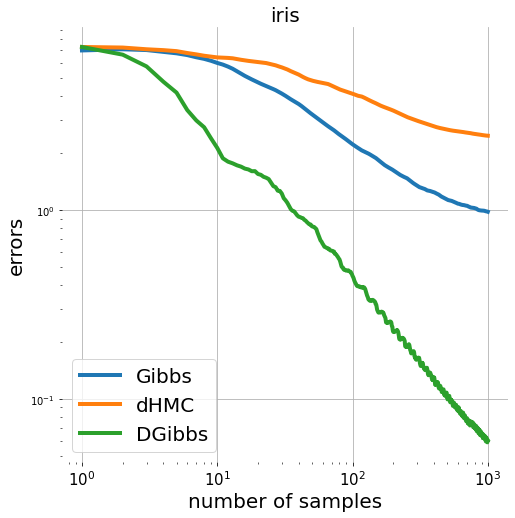

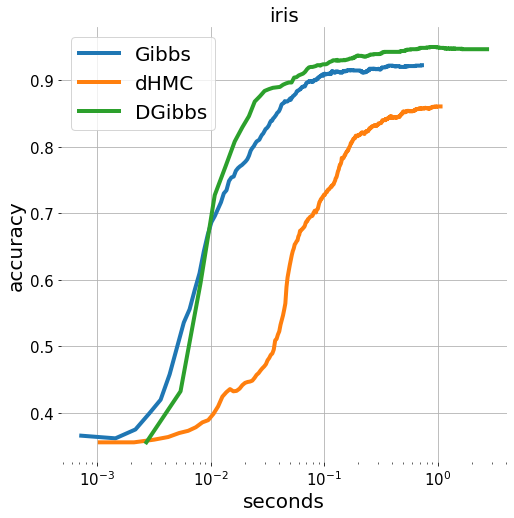

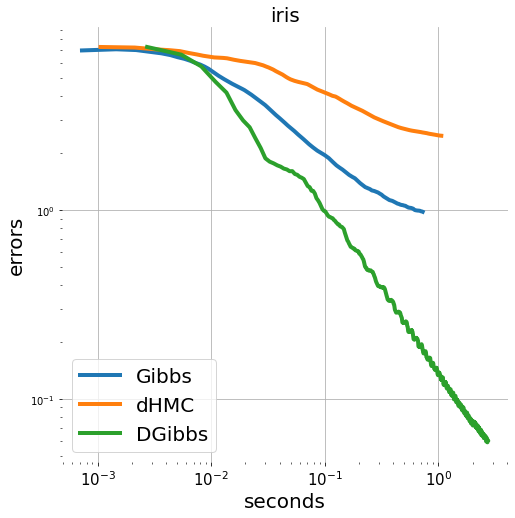

In [17]:
plot_results('iris')

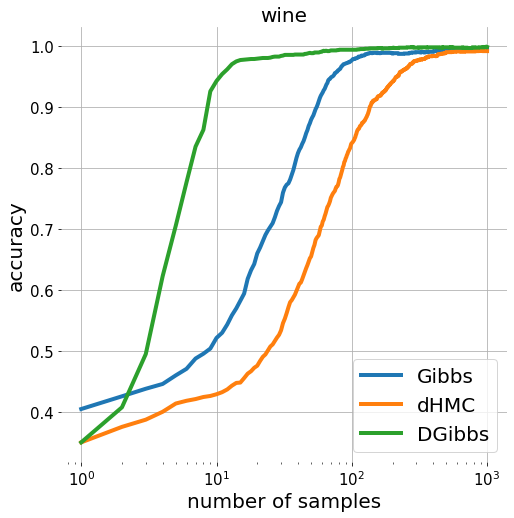

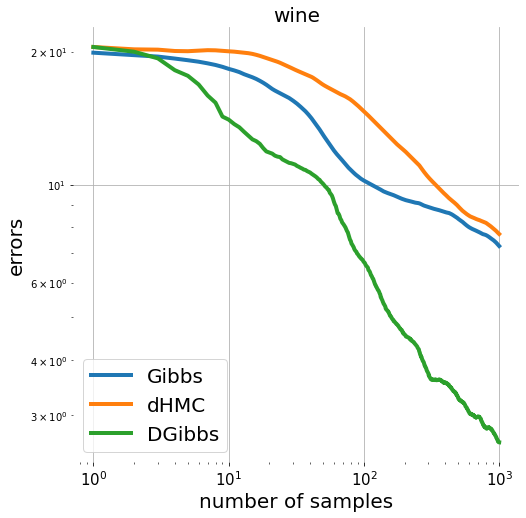

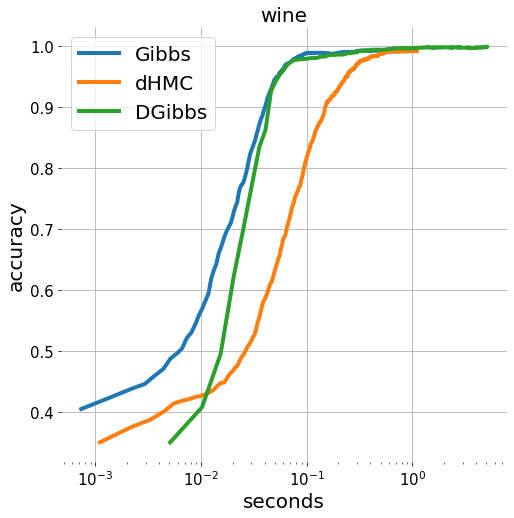

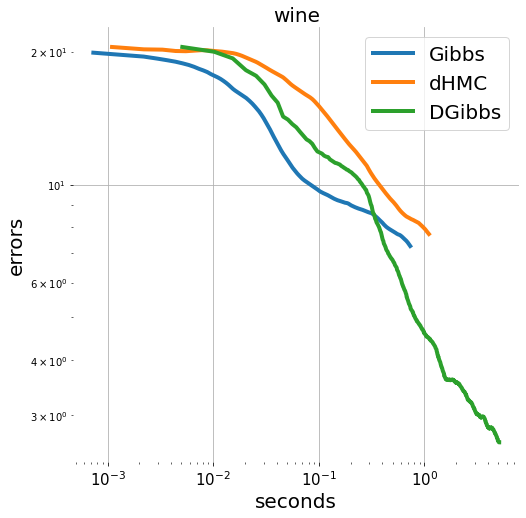

In [18]:
plot_results('wine')

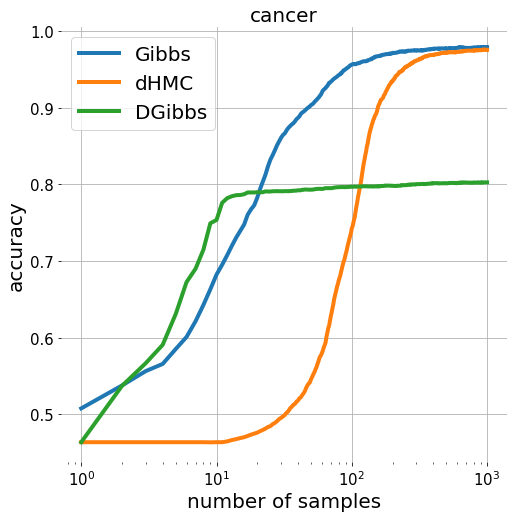

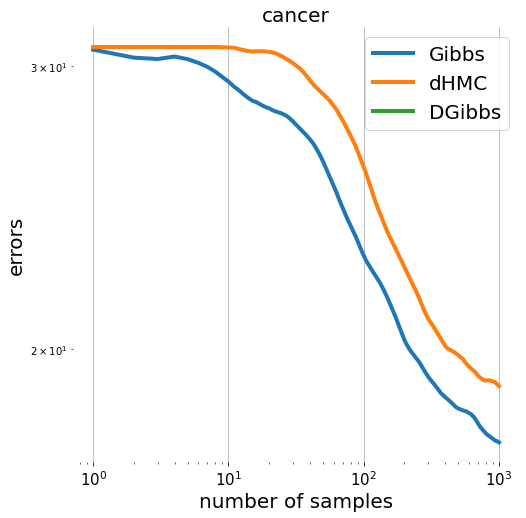

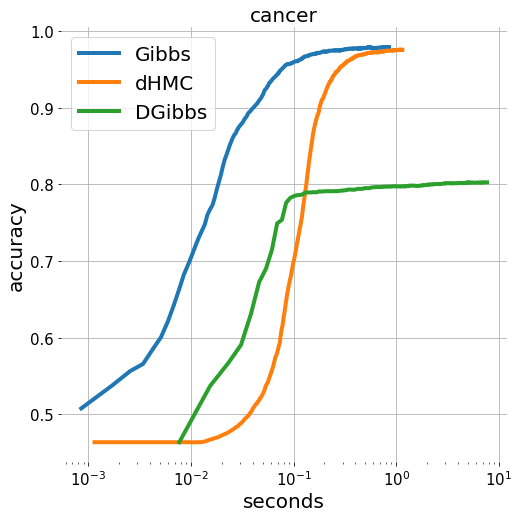

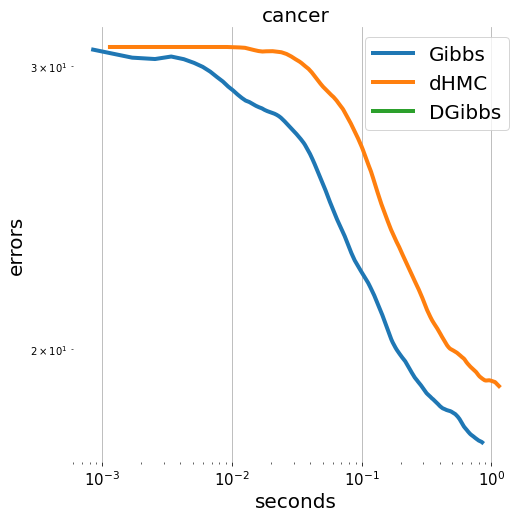

In [23]:
plot_results('cancer')

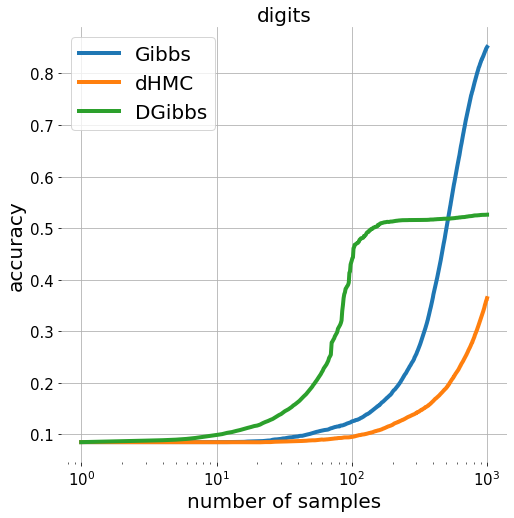

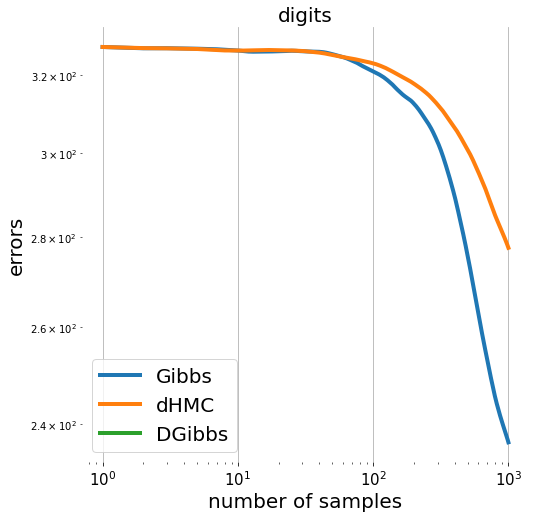

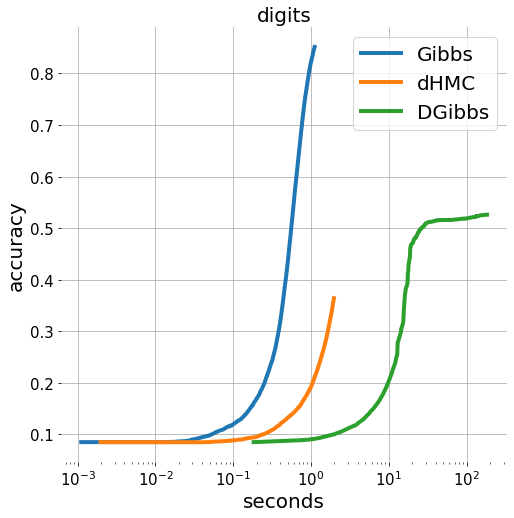

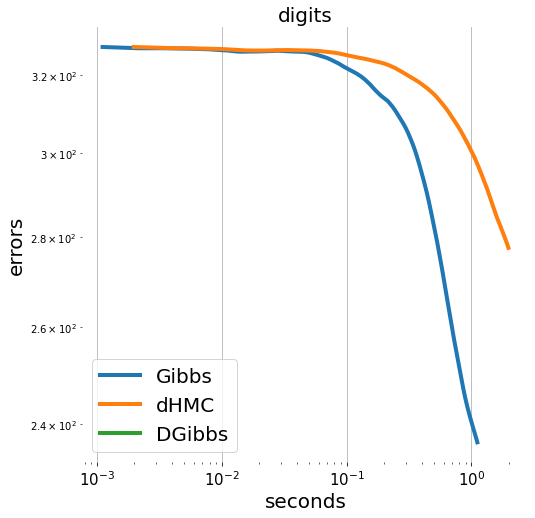

In [24]:
plot_results('digits')